Notebook del modelo de árbol de decisión del dataframe de las peleas ponderadas

- **Tarea del backlog:** https://github.com/UCM-GIDIA-PD1/c2425-R4/issues/31
- **Propósito del código:** Árbol de clasificación para el dataframe de peleas ponderadas (P2).
- **Autor(es):** Carlos Vallejo.  
- **Descripción y uso:** Ejecutar para ver el resultado del modelo de árbol de clasificación en P2.
- **Estado actual:** Primer modelo, falta mejorarlo.

In [3]:
#NO BORRAR ESTA CELDA!!!!!!!!!!!!!!!!

#Marca con un * al final las que ya estén solucionadas

#Solucionar:
#No hay estudio de transformaciones *
#Se evaluan los modelos con accuracy en vez de f1-score (se explica el porque en la memoria) *
#Explica cada modelo un poco: que hace, porque lo usas
#No hay estudio de selección de variables. Si es necesario hacer una selección indicar que algoritmo de selección de variables usar. *

In [4]:
import os
import pandas as pd
import numpy as np
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score,log_loss, f1_score, roc_auc_score, precision_score, recall_score #, make_scorer
#from sklearn.preprocessing import MinMaxScaler
from sklearn import tree  
from sklearn.tree import plot_tree

import seaborn as sns
import matplotlib.pyplot as plt

In [6]:
#los parquet ya están divididos entre train, test y validación
ruta_train =  os.path.join("..","..","..", "data", "P2","train.parquet")
train = pd.read_parquet(ruta_train)
train.head()

,DATE,Peleador_A,Peleador_B,WINNER,KD_A,KD_B,SIG_STR_A,SIG_STR_B,TD_PORC_A,TD_PORC_B,...,Derrotas_Sub_A,Derrotas_Sub_B,Derrotas_Decision_A,Derrotas_Decision_B,KD_DIFF,SIG_STR_DIFF,TD_DIFF,SUB_ATT_DIFF,REV_DIFF,CTRL_DIFF
0,2000-06-09,Kevin Randleman,Pedro Rizzo,False,0.0,0.8,0.279,0.315,0.770,0.000,...,0.0,0.0,0.8,0.0,-0.8,-0.036,0.615385,1.0,0.0,526.0
1,2000-09-22,Jeremy Horn,Eugene Jackson,False,0.0,0.5,0.696,0.550,0.084,0.000,...,0.0,0.5,0.0,0.0,-0.5,0.146,0.250000,0.4,0.0,3.3
2,2001-02-23,Tito Ortiz,Evan Tanner,False,0.3,0.0,0.552,0.741,0.874,1.000,...,0.0,0.0,0.0,0.0,0.3,-0.189,0.178571,-0.1,0.0,458.1
3,2001-05-04,Chuck Liddell,Kevin Randleman,False,0.0,0.0,0.508,0.532,0.000,0.758,...,1.0,0.0,0.0,1.0,0.0,-0.024,-0.518519,-1.5,0.2,-455.0
4,2001-06-29,Pat Miletich,Shonie Carter,False,0.0,1.0,0.451,0.521,0.500,0.646,...,0.5,0.0,0.0,0.0,-1.0,-0.070,0.037945,0.8,-1.2,-137.3


In [7]:
ruta_val = os.path.join("..","..","..", "data", "P2","validation.parquet")
val = pd.read_parquet(ruta_val)
val.head()

,DATE,Peleador_A,Peleador_B,WINNER,KD_A,KD_B,SIG_STR_A,SIG_STR_B,TD_PORC_A,TD_PORC_B,...,Derrotas_Sub_A,Derrotas_Sub_B,Derrotas_Decision_A,Derrotas_Decision_B,KD_DIFF,SIG_STR_DIFF,TD_DIFF,SUB_ATT_DIFF,REV_DIFF,CTRL_DIFF
0,2021-06-26,Yancy Medeiros,Damir Hadzovic,True,0.0,0.0,0.261,0.323,0.000,0.432,...,1.0,0.5,1.5,1.8,0.0,-0.062,-0.368421,0.0,0.3,-59.5
1,2021-07-10,Tai Tuivasa,Greg Hardy,False,0.8,0.3,0.661,0.544,0.000,0.300,...,1.0,0.0,1.0,1.0,0.5,0.117,-0.230769,0.0,0.0,-20.0
2,2021-07-10,Irene Aldana,Yana Santos,False,0.3,0.0,0.367,0.731,0.000,0.150,...,0.0,0.0,3.5,0.0,0.3,-0.364,-0.187500,0.0,-0.2,-437.6
3,2021-07-10,Dustin Poirier,Conor McGregor,False,0.5,0.3,0.518,0.558,0.542,0.000,...,2.0,2.0,1.0,0.0,0.2,-0.040,0.222222,1.4,0.0,64.3
4,2021-07-10,Gilbert Burns,Stephen Thompson,False,0.2,0.3,0.547,0.467,0.075,0.000,...,0.0,0.0,2.0,3.0,-0.1,0.080,0.122449,0.3,0.0,140.9


In [8]:
ruta_test = os.path.join("..","..","..", "data", "P2","test.parquet")
test = pd.read_parquet(ruta_test)
test.head()

,DATE,Peleador_A,Peleador_B,WINNER,KD_A,KD_B,SIG_STR_A,SIG_STR_B,TD_PORC_A,TD_PORC_B,...,Derrotas_Sub_A,Derrotas_Sub_B,Derrotas_Decision_A,Derrotas_Decision_B,KD_DIFF,SIG_STR_DIFF,TD_DIFF,SUB_ATT_DIFF,REV_DIFF,CTRL_DIFF
0,2023-04-22,Rani Yahya,Montel Jackson,True,0.0,2.1,0.569,0.513,0.415,0.240,...,0.0,0.0,5.0,2.0,-2.1,0.056,0.047222,0.5,0.7,140.0
1,2023-04-22,Jeremiah Wells,Matthew Semelsberger,False,0.7,1.8,0.529,0.382,0.060,0.800,...,0.0,0.0,0.0,1.8,-1.1,0.147,-0.403226,0.3,0.0,-111.5
2,2023-04-29,Caio Borralho,Michal Oleksiejczuk,False,0.0,0.6,0.565,0.510,0.690,0.100,...,0.0,2.0,0.0,1.0,-0.6,0.055,0.370656,1.0,1.2,414.4
3,2023-04-29,Song Yadong,Ricky Simon,False,0.5,0.8,0.379,0.595,0.500,0.407,...,0.0,0.0,1.0,1.0,-0.3,-0.216,0.150000,-0.7,0.0,-244.9
4,2023-04-29,Rodolfo Vieira,Cody Brundage,False,0.0,0.3,0.528,0.214,0.305,0.700,...,1.0,0.0,0.5,1.0,-0.3,0.314,-0.393102,0.1,0.0,62.6


TRANSFORMACIONES

No es necesario hacer transformaciones para hacer un árbol de decisión ya que estos pueden manejar los datos sin estos cambios.

SELECCIÓN DE VARIABLES

Tampoco es necesario hacer una selección de variables ya que los árboles de decisión no se ven afectados por diferencias en las magnitudes de las variables, además de que el propio árbol selecciona las características más relevantes de las variables.

AJUSTE DE HIPERPARÁMETROS

Para ajustar los parámetros hemos utilizado dos estrategias, GridSearchCV y RandomizedSearchCV.

In [16]:
def train_decision_tree_grid(X_train, y_train, X_val, y_val):
    from sklearn.tree import plot_tree
    # Calcular pesos de clase para manejar desbalance de datos
    class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
    class_weight_dict = {i: class_weights[i] for i in range(len(class_weights))}

    # Definir modelo base
    dt = DecisionTreeClassifier(random_state=42)

    # Cuadrícula de hiperparámetros
    param_grid = {
        'criterion': ['gini', 'entropy'],  # Función para medir la calidad de la división
        'max_depth': [3],  # Profundidad máxima del árbol
        'min_samples_split': [2, 5, 10],  # Mínimo de muestras para dividir un nodo
        'min_samples_leaf': [1, 2, 4],  # Mínimo de muestras en una hoja
        'class_weight': [None, class_weight_dict]  # Ajuste de pesos por clase
    }

    #f1_scorer = make_scorer(f1_score, average='macro')

    # Búsqueda de hiperparámetros con validación cruzada
    grid_search = GridSearchCV(
        estimator=dt,
        param_grid=param_grid,
        scoring="accuracy",
        cv=5,
        n_jobs=-1,
        verbose=2
    )

    # Entrenar el modelo
    grid_search.fit(X_train, y_train)

    # Imprimir mejores parámetros
    print("Mejores parámetros:", grid_search.best_params_)

    # Evaluar el mejor modelo en el conjunto de validación
    y_pred = grid_search.best_estimator_.predict(X_val)
    print("Reporte de clasificación:")
    print(classification_report(y_val, y_pred))

    # Visualización del árbol
    plt.figure(figsize=(15, 8))
    plot_tree(grid_search.best_estimator_, filled=True, feature_names=X_train.columns, class_names=["False", "True"])
    plt.show()

    return grid_search.best_estimator_

Fitting 5 folds for each of 36 candidates, totalling 180 fits
Mejores parámetros: {'class_weight': None, 'criterion': 'entropy', 'max_depth': 3, 'min_samples_leaf': 1, 'min_samples_split': 2}
Reporte de clasificación:
              precision    recall  f1-score   support

       False       0.53      0.99      0.69       277
        True       0.50      0.01      0.02       244

    accuracy                           0.53       521
   macro avg       0.52      0.50      0.35       521
weighted avg       0.52      0.53      0.38       521



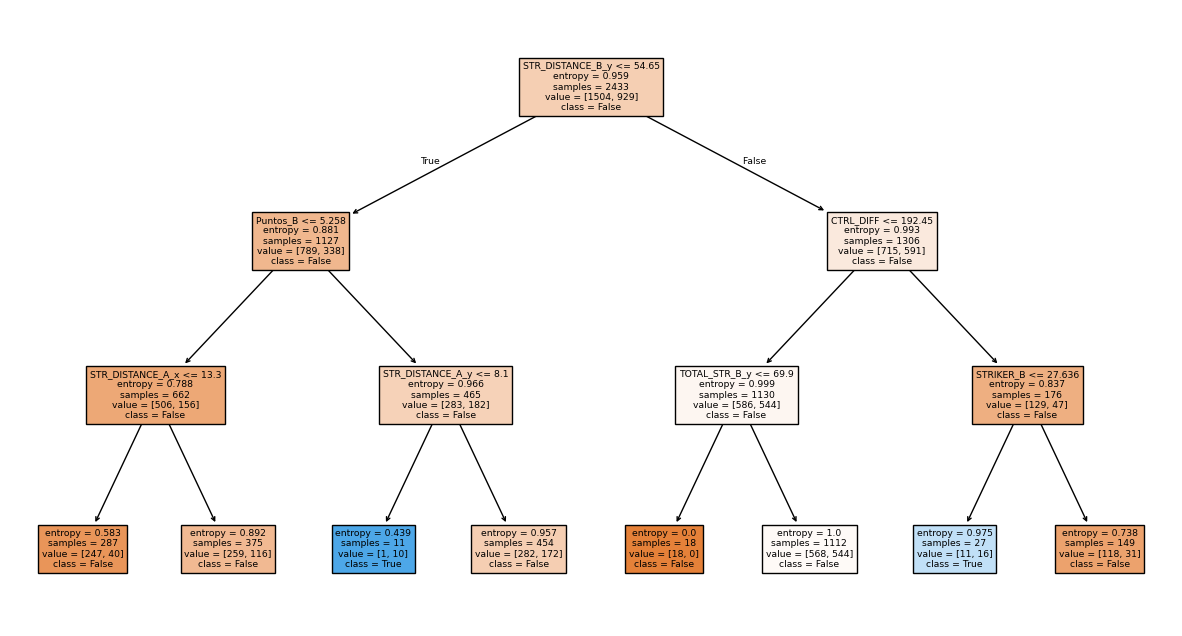

In [17]:
columnasQuitar = ["DATE","Peleador_A","Peleador_B", "WINNER"] #categóricas y variable respuesta

X_train = train.drop(columns=columnasQuitar)
y_train = train['WINNER']
X_val = val.drop(columns=columnasQuitar)
y_val = val['WINNER']

#scaler = MinMaxScaler()
#X_train_normalized = scaler.fit_transform(X_train)
#X_val_normalized = scaler.transform(X_val)
#no mejora normalizando los datos


tree = train_decision_tree_grid(X_train, y_train, X_val, y_val)

El árbol de decisión con 3 niveles como máximo no es óptimo pero sirve para observar que variables son más importantes para las divisiones internas del árbol.

In [24]:
#Observamos todos los valores de las métricas.
print("-- Métricas del modelo con hiperparámetros ajustados --")
y_val_pred = tree.predict(X_val)
y_val_prob = tree.predict_proba(X_val)[:,1]
print("Accuracy:", accuracy_score(y_val, y_val_pred))
f1_val = f1_score(y_val, y_val_pred)
roc_auc_val = roc_auc_score(y_val, y_val_prob)
precision_val = precision_score(y_val, y_val_pred)
recall_val = recall_score(y_val, y_val_pred)
log_loss_val = log_loss(y_val,y_val_prob)
print(f"F1-Score: {f1_val:.4f}")
print(f"AUC-ROC: {roc_auc_val:.4f}")
print(f"Precisión: {precision_val:.4f}")
print(f"Sensibilidad: {recall_val:.4f}")
print(f"Log-loss: {log_loss_val}")
print(confusion_matrix(y_val, y_val_pred))


-- Métricas del modelo con hiperparámetros ajustados --
Accuracy: 0.5316698656429942
F1-Score: 0.0161
AUC-ROC: 0.5061
Precisión: 0.5000
Sensibilidad: 0.0082
Log-loss: 0.6995369806820841
[[275   2]
 [242   2]]


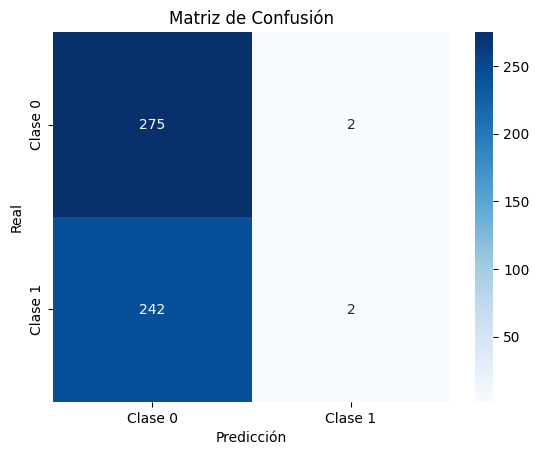

In [19]:
# Calcular la matriz de confusión
cm = confusion_matrix(y_val, y_val_pred)

# Visualizar la matriz de confusión
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Clase 0', 'Clase 1'], yticklabels=['Clase 0', 'Clase 1'])
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.title('Matriz de Confusión')
plt.show()

Como vemos, con Grid Search el modelo tiene un recall y f1-score bastante alto cuando predice False y bastante bajo cuando predice True. Además, casi siempre predice False. Vamos a probar con Random Search para ver si podemos conseguir un mejor modelo.

In [20]:
def train_decision_tree_random(X_train, y_train, X_val, y_val):
    from sklearn.tree import plot_tree
    # Calcular pesos de clase para manejar desbalance de datos
    class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
    class_weight_dict = {cls: weight for cls, weight in zip(np.unique(y_train), class_weights)}

    # Definir modelo base
    dt2 = DecisionTreeClassifier(random_state=42, class_weight=class_weight_dict)

    # Distribución de hiperparámetros para búsqueda aleatoria
    param_dist = {
    "criterion": ["gini", "entropy"],
    "max_depth": [int(3)],
    "min_samples_split": [int(x) for x in np.arange(2, 20, 2)],
    "min_samples_leaf": [int(x) for x in np.arange(1, 20, 2)],
    "max_features": ["sqrt", "log2", None],
    "splitter": ["best", "random"],
    }
    #  ['ccp_alpha', 'class_weight', 'max_leaf_nodes', 'min_impurity_decrease',
    #  'min_weight_fraction_leaf', 'monotonic_cst', 'random_state']  otros posibles parámetros

    # Definir la métrica de optimización como el F1-score macro
    #f1_scorer = make_scorer(f1_score, average='macro')

    # Búsqueda con validación cruzada
    random_search = RandomizedSearchCV(
        estimator=dt2,
        param_distributions=param_dist,
        scoring="accuracy",
        n_iter=50,
        cv=5,
        n_jobs=-1,
        verbose=2,
        random_state=42
    )


    # Entrenar el modelo
    random_search.fit(X_train, y_train)

    # Imprimir mejores parámetros
    print("Mejores parámetros:", random_search.best_params_)

    # Evaluar el mejor modelo en el conjunto de validación
    y_pred = random_search.best_estimator_.predict(X_val)
    print("Reporte de clasificación:")
    print(classification_report(y_val, y_pred))

    plt.figure(figsize=(15, 8))
    plot_tree(random_search.best_estimator_, filled=True, feature_names=X_train.columns, class_names=["False", "True"], max_depth=3)
    plt.show()

    return random_search.best_estimator_

-- Entrenamiento usando ajuste de hiperparámetros con RandomizedSeachCV --
Fitting 5 folds for each of 50 candidates, totalling 250 fits
Mejores parámetros: {'splitter': 'best', 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 3, 'criterion': 'entropy'}
Reporte de clasificación:
              precision    recall  f1-score   support

       False       0.51      0.36      0.42       277
        True       0.46      0.61      0.52       244

    accuracy                           0.48       521
   macro avg       0.48      0.48      0.47       521
weighted avg       0.48      0.48      0.47       521



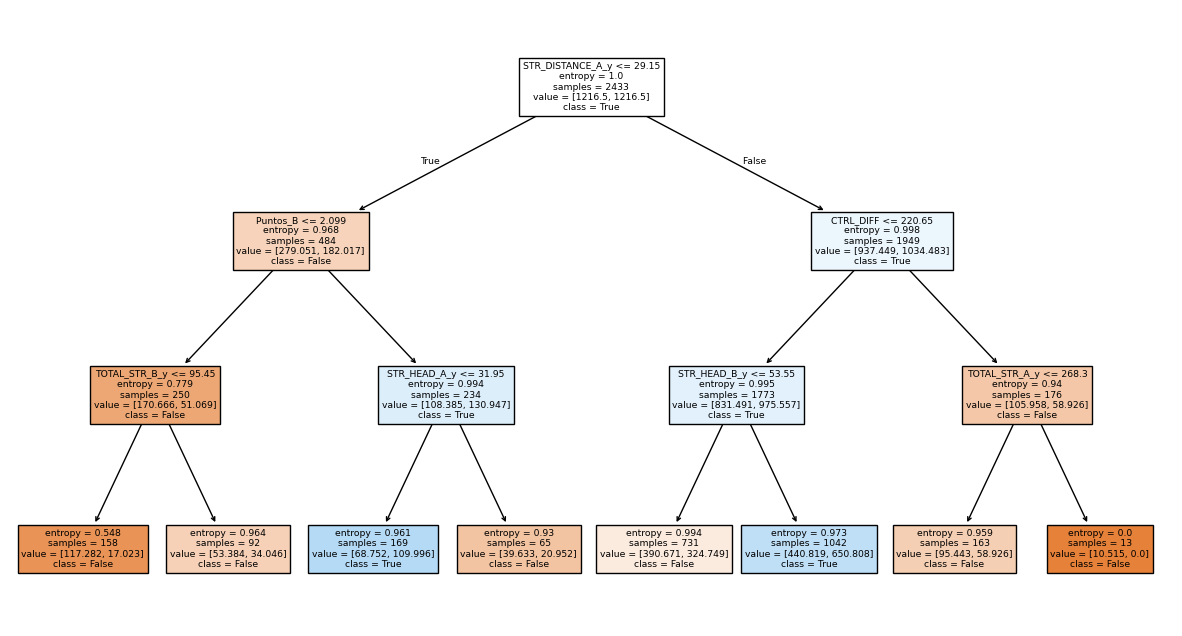

In [21]:
print("-- Entrenamiento usando ajuste de hiperparámetros con RandomizedSeachCV --")
tree2 = train_decision_tree_random(X_train,y_train,X_val,y_val)

In [ ]:
#Observamos todos los valores de las métricas.
print("-- Métricas del modelo con hiperparámetros ajustados --")
y_val_pred = tree2.predict(X_val)
y_val_prob = tree2.predict_proba(X_val)[:,1]
print("Accuracy:", accuracy_score(y_val, y_val_pred))
f1_val = f1_score(y_val, y_val_pred)
roc_auc_val = roc_auc_score(y_val, y_val_prob)
precision_val = precision_score(y_val, y_val_pred)
recall_val = recall_score(y_val, y_val_pred)
log_loss_val = log_loss(y_val,y_val_prob)

print(f"F1-Score: {f1_val:.4f}")
print(f"AUC-ROC: {roc_auc_val:.4f}")
print(f"Precisión: {precision_val:.4f}")
print(f"Sensibilidad: {recall_val:.4f}")
print(f"Log-loss: {log_loss_val}")
print(confusion_matrix(y_val, y_val_pred))



-- Métricas del modelo con hiperparámetros ajustados --
Accuracy: 0.4760076775431862
F1-Score: 0.5219
AUC-ROC: 0.4972
Precisión: 0.4557
Sensibilidad: 0.6107
Log-loss: 0.7189185990851892
[[ 99 178]
 [ 95 149]]


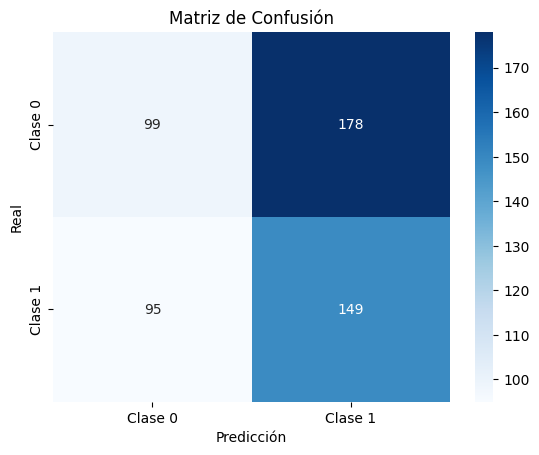

In [23]:
# Calcular la matriz de confusión
cm = confusion_matrix(y_val, y_val_pred)

# Visualizar la matriz de confusión
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Clase 0', 'Clase 1'], yticklabels=['Clase 0', 'Clase 1'])
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.title('Matriz de Confusión')
plt.show()

En este caso vemos que el modelo de Random Search no está tan desbalanceado en cuanto a la predicción, aunque también es muy mejorable como modelo.